# Graphing and Relationship Extraction of Dark Tv Series
If you have seen the Dark series produced by Netflix, you know that understanding this series and the relationship between the characters can be challenging. In this project, I used biographies of serial characters and NLP and Graph Analysis to determine the relationship between serial characters and their importance.

## Project Overview : 
### 1- Extracting .text Files and Combine Them All Together
### 2- Extracting Relationships from Characters Biography
### 3- Extracting Characters Names and Edging Based on Their Relationships
### 4- Ploting Relationships Graph
### 5- Who Are The Top 10 Most Important Charecters in Tv Show
### 6- Who Are The Top Top 10 Intermediarie Charecters in Dark
### 7- Who Are The Top 10 Communicator in Dark

In [1]:
# Data Preprocessing
import pandas as pd

# Extracting Names and Relations
import spacy

# Graphing Relationships
import community as community_louvain
import networkx as nx

# Data Visualization
from pyvis.network import Network
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


# Extracting texts from .text files
import os


# Visualization Setups
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")
%matplotlib inline

## Extracting .text Files and Combine Them All Together

In [2]:
directory = 'Drak'
combined_text = '' 

for filename in os.listdir(directory):
    if filename.endswith(".text"):
        with open(os.path.join(directory, filename), 'r') as file:
            text = file.read()
            combined_text += text 


## Extracting Relationships from Characters Biography

In [3]:
def clean_name(txt):
    """
    This function take Extracted names from combined_text and 
    clean them. Some charecters may have multi name with one personality
    and some charecters names may have some extras. At the end 
    all remain is charecter names without last-name
    """
    txt=txt.replace(".[2]After Jonas's", "")
    txt=txt.replace("sex.[4]", "")
    txt=txt.replace("Michael/Mikkel", "Mikkel")
    txt=txt.replace("Michael", "Mikkel")
    txt=txt.replace("Aleksander", "Alexander")
    txt=txt.replace("added", "")
    txt=txt.replace("Hannoh", "Noah")
    txt=txt.split(' ')[0]
    return txt

## Extracting Characters Names and Edging Based on Their Relationships 

In [4]:
nlp = spacy.load('en_core_web_sm')


def extract_relationships(text):
    doc = nlp(text)
    G = nx.Graph()
    for sent in doc.sents:
        # get named entities in the sentence
        entities = [ent.text for ent in sent.ents if ent.label_ == 'PERSON']
        # apply cleaning function
        entities = [clean_name(s) for s in entities]
        # add edges between named entities in the sentence
        for i, source in enumerate(entities):
            for j, target in enumerate(entities):
                if i != j:
                    # check if edge already exists in the graph
                    if G.has_edge(source, target):
                        # increment the weight of the edge
                        G[source][target]['weight'] += 1
                    else:
                        # add a new edge with weight of 1
                        G.add_edge(source, target, weight=1)
    return G

G = extract_relationships(combined_text)


# Create graph from a pandas dataframe
df = nx.to_pandas_edgelist(G)

In [5]:
df.head(5)

,source,target,weight
0,Alexander,Boris,4
1,Alexander,Hannah,2
2,Alexander,Torben,2
3,Alexander,Bartosz,2
4,Boris,Hannah,2


In [6]:
# Create graph from pandas dataframe 
Graph = nx.from_pandas_edgelist(df,
                           source='source',
                           target='target',
                           edge_attr='weight',
                           create_using=nx.Graph())

### Ploting Relationships Graph

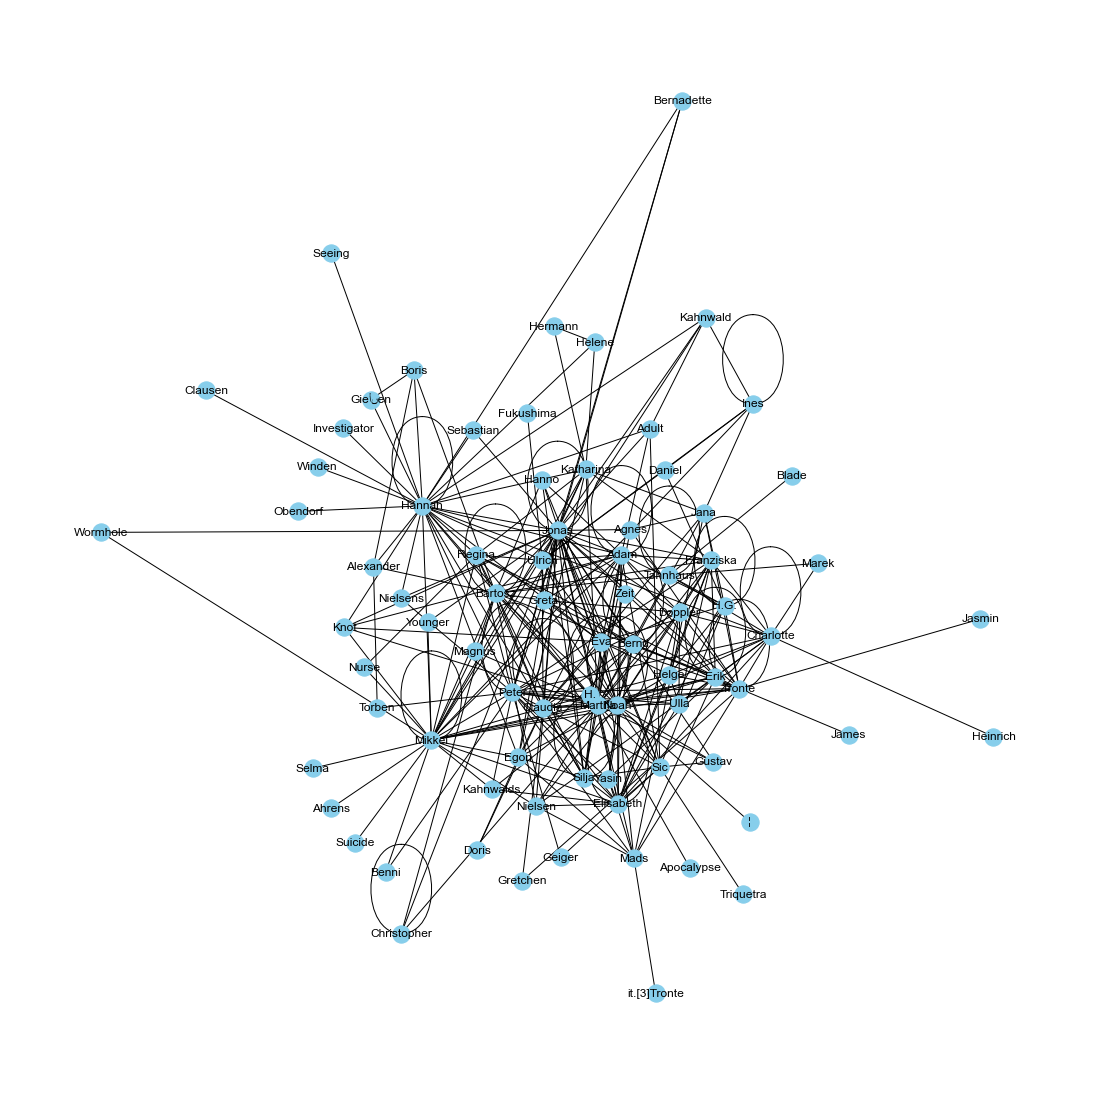

In [7]:
plt.figure(figsize=(15,15))
pos = nx.kamada_kawai_layout(Graph)
nx.draw(Graph,with_labels=True,node_color='skyblue',edge_cmap=plt.cm.Blues,pos=pos)

### Which Characters Are the Most Important (Based on Degree Centrality)

- ### 🟣 Most Important
- ### 🔴 Semi Important
- ### 🟡 Moderate Important
- ### 🟢 Secondary characters
- ### 🔵 NPCs

In [17]:
net = Network(notebook=True,height="800px", width="100%",bgcolor='#222222',font_color='white')
net.toggle_hide_edges_on_drag(True)
net.barnes_hut(gravity=-500)
node_degree = dict(Graph.degree)
        
nx.set_node_attributes(Graph,node_degree,'size')
net.from_nx(Graph)
for n in net.nodes:
    if 5 > n['size'] :
        n['color'] = 'blue'
    if n['size'] > 10:
        n['color'] = 'green'
    if n['size'] > 20:
        n['color'] = 'yellow'
    if n['size'] > 25:
        n['color'] = 'purple'    
    if n['size'] > 30:
        n['color'] = 'red'

net.show('dark_degrees.html')

dark_degrees.html


### Top 10 Most Important Charecters in Dark

<AxesSubplot:title={'center':'Top 10 Most Important Charecters'}>

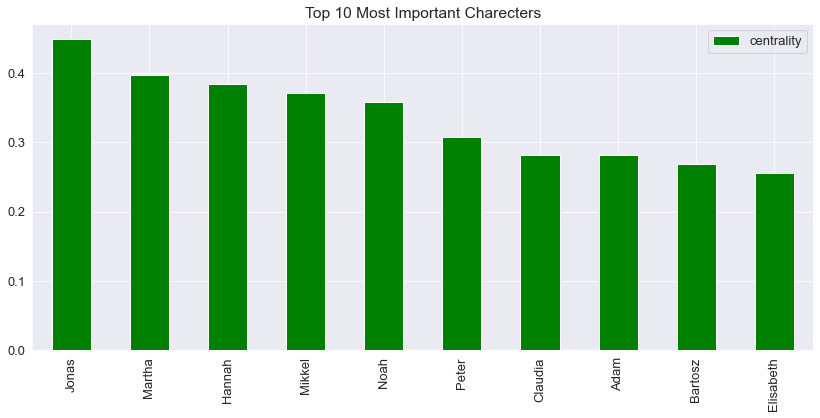

In [21]:
degreee_dict = nx.degree_centrality(Graph)
degreee_df = pd.DataFrame.from_dict(degreee_dict,orient='index',columns=['centrality'])
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams.update({'font.size': 13})

degreee_df.sort_values('centrality',ascending=False)[0:10].plot(kind="bar",color='green',title='Top 10 Most Important Charecters')

### Top 10 Intermediarie Charecters in Dark

<AxesSubplot:title={'center':'Top 10 Intermediarie Charecters'}>

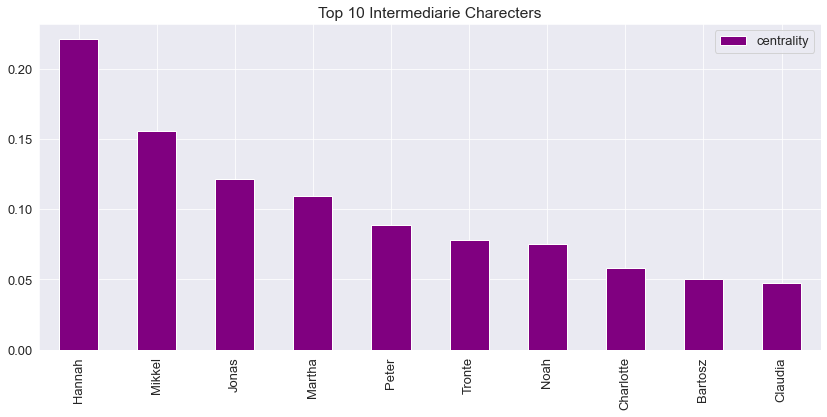

In [22]:
betwenness_dict = nx.betweenness_centrality(Graph)

betwenness_df = pd.DataFrame.from_dict(betwenness_dict,orient='index',columns=['centrality'])
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams.update({'font.size': 13})

betwenness_df.sort_values('centrality',ascending=False)[0:10].plot(kind="bar",color='purple',title='Top 10 Intermediarie Charecters')

### Top 10 Communicator in Dark

<AxesSubplot:title={'center':'Top 10 Communicator'}>

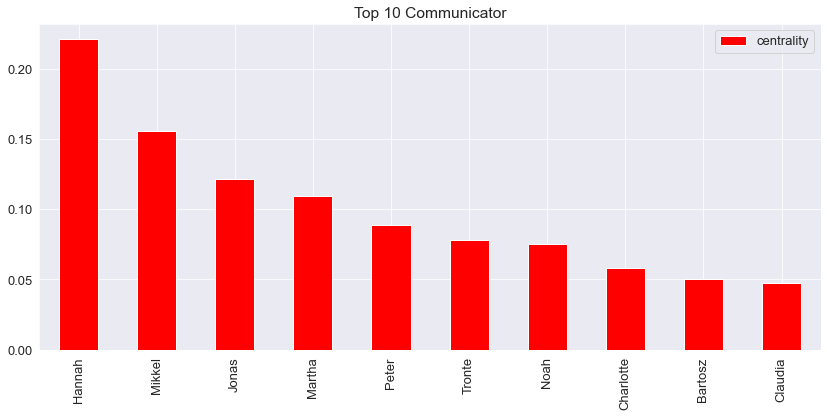

In [23]:
closeness_dict = nx.closeness_centrality(Graph)

plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams.update({'font.size': 13})
closeness_df =  pd.DataFrame.from_dict(betwenness_dict,orient='index',columns=['centrality'])
closeness_df.sort_values('centrality',ascending=False)[0:10].plot(kind="bar",color='red',title='Top 10 Communicator')

### Detecting Communities Between the characters

In [12]:
nx.set_node_attributes(Graph,degreee_dict,'degreee_centrality')
nx.set_node_attributes(Graph,betwenness_dict,'betwenness_centrality')
nx.set_node_attributes(Graph,closeness_df,'closeness_centrality')

In [13]:
communities = community_louvain.best_partition(Graph)

In [14]:
communities

{'Alexander': 1,
 'Boris': 1,
 'Hannah': 1,
 'Torben': 1,
 'Bartosz': 3,
 'Gieأںen': 1,
 'Ulrich': 4,
 'Katharina': 5,
 'Regina': 5,
 'Fukushima': 4,
 'Daniel': 2,
 'Ines': 2,
 'Greta': 4,
 'Adam': 4,
 'Eva': 4,
 'Noah': 0,
 'Claudia': 2,
 'Mikkel': 5,
 'Helene': 5,
 'Hermann': 5,
 'Martha': 3,
 'Franziska': 0,
 'Jonas': 1,
 'Jana': 2,
 'Egon': 2,
 'Bernd': 2,
 'Nurse': 5,
 'Peter': 0,
 'Tronte': 2,
 'Seeing': 1,
 'Silja': 4,
 'Sebastian': 1,
 'Charlotte': 0,
 'Adult': 1,
 'Kahnwald': 1,
 'Investigator': 1,
 'Clausen': 1,
 'Winden': 1,
 'Obendorf': 1,
 'Bernadette': 1,
 'Knot': 4,
 'Nielsens': 1,
 'Elisabeth': 0,
 'Nielsen': 3,
 'Tannhaus': 3,
 'Mads': 3,
 'Apocalypse': 3,
 'Sic': 4,
 'Gustav': 4,
 'Kahnwalds': 0,
 'Erik': 3,
 'Christopher': 3,
 'Agnes': 2,
 'Magnus': 3,
 'Doppler': 0,
 'Marek': 3,
 'Heinrich': 0,
 'Helge': 0,
 'Ulla': 0,
 'Yasin': 0,
 'Hanno': 4,
 'Younger': 5,
 'Wormhole': 5,
 'Selma': 5,
 'Ahrens': 5,
 'Suicide': 5,
 'Benni': 5,
 '¦': 0,
 'Doris': 2,
 'Gretchen': 2,

In [15]:
nx.set_node_attributes(Graph,communities,'group')

In [16]:
net = Network(notebook=True,height="800px", width="100%",bgcolor='#222222',font_color='white')
net.barnes_hut(gravity=-800)
node_degree = dict(Graph.degree)
net.from_nx(Graph)


net.show('dark.html')

dark.html
